In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join as pjoin
from tqdm import tqdm

In [146]:
def low_clip(x, low = 0):
    return low if x < low else x

In [156]:
image_idx = 0
image_path = pjoin('images',f'image{image_idx}.png')

In [157]:
# Список для хранения координат кликов
click_coordinates = []

In [158]:
# Загрузка изображения
image = cv2.imread(image_path)

image_copy = np.copy(image)

In [159]:
# Функция обработки событий мыши
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Если была нажата левая кнопка мыши
        global click_coordinates
        click_coordinates.append((x, y))  # Добавляем координаты клика в список
        cv2.circle(image_copy, (x, y), 3, (0, 255, 0), -1)  # Рисуем круг на месте клика

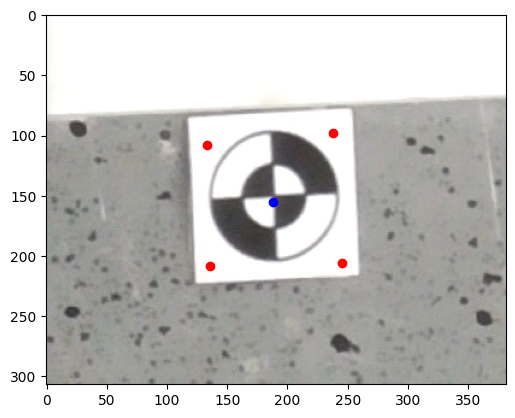

In [160]:
click_coordinates = []

# Загрузка изображения
image = cv2.imread(image_path)

image_copy = np.copy(image)

# Создание окна для отображения изображения
cv2.namedWindow('Image')

# Установка функции обратного вызова для событий мыши
cv2.setMouseCallback('Image', mouse_callback)

while True:
    # Отображение изображения
    cv2.imshow('Image', image_copy)

    # Ожидание нажатия клавиши "Esc" для выхода
    if cv2.waitKey(1) == 27 or cv2.waitKey(1) == 13:
        break

# print(click_coordinates)

click_coordinates = np.array(click_coordinates)
center = click_coordinates.mean(axis=0)

# print(center)

# Отображение мест кликов
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
for coordinate in click_coordinates:
    plt.plot(coordinate[0], coordinate[1], 'ro')

plt.plot(center[0], center[1], 'bo')
plt.show()


# Закрытие окна
cv2.destroyAllWindows()

In [161]:
click_coordinates = np.array(click_coordinates)
rad = int(max(((click_coordinates - center)**2).sum(axis=1)**0.5))
center = center.astype(int)

In [162]:
image_copy = image.copy()
print(image_copy.shape)
cv2.namedWindow('Image')
cv2.circle(image_copy, center, rad, (0, 255, 255), -1)
cv2.imshow('Image', image_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

(307, 382, 3)


In [163]:
image_copy = image.copy()

In [164]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [165]:
mark_part = image_gray[center[1] - rad:center[1] + rad, center[0] - rad:center[0] + rad]

In [166]:
# mask = np.zeros_like(mark_part)
diam = mark_part.shape[0]
for x in range(0, diam):
    _pad = int(diam//2  - low_clip(diam**2//4 - (x-diam//2)**2)**0.5)
    for y in range(0, _pad):
        mark_part[x][y] = 255
    for y in range(diam - _pad, diam):
        mark_part[x][y] = 255


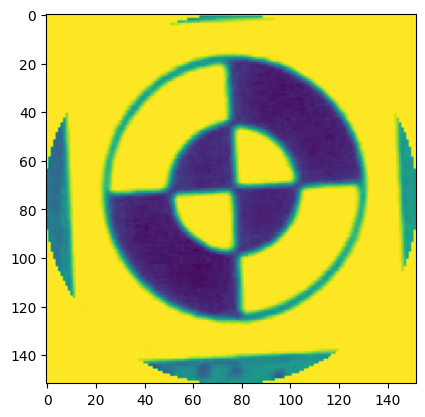

In [168]:
plt.imshow(mark_part)

In [183]:
ret, thresh = cv2.threshold(mark_part, 127, 255, 0)
contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [184]:
thresh = 255 - thresh

In [185]:
contours_image, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

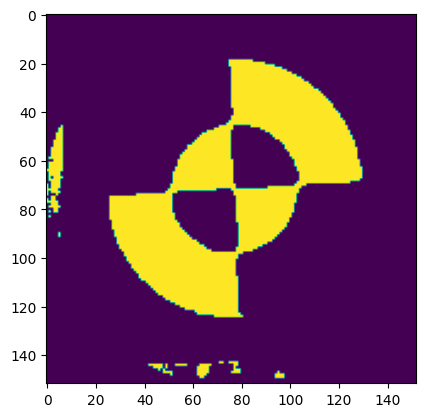

In [186]:
plt.imshow(thresh)

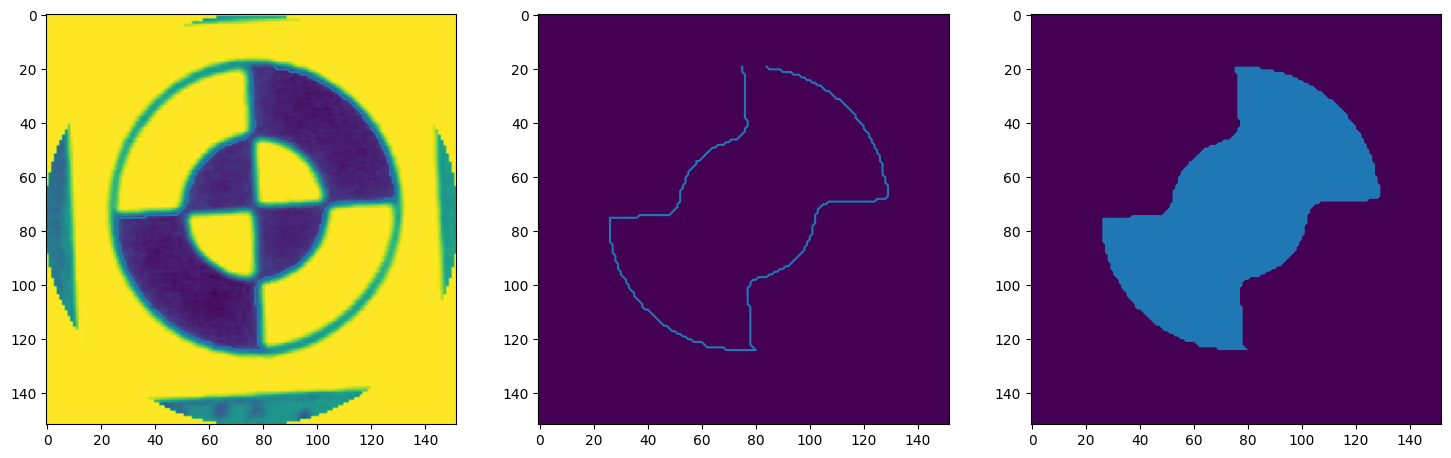

In [200]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
# ax[0].imshow(mark_part)
ax[0].imshow(mark_part)
ax[1].imshow(np.zeros_like(mark_part))
ax[2].imshow(np.zeros_like(mark_part))
part_area = mark_part.shape[0]*mark_part.shape[1]
min_area_lim = part_area / 12
max_area_lim = part_area * 0.9
best_cntr = contours_image[0]
best_cntr_area = cv2.contourArea(best_cntr)
for cntr in contours_image:
    area = cv2.contourArea(cntr)
    if area > min_area_lim and area < max_area_lim:
        if (area > best_cntr_area):
            best_cntr = cntr
            best_cntr_area = area
        cntr_np = np.array(cntr).reshape(-1, 2)
        ax[0].plot(cntr_np[:,0], cntr_np[:,1])
        ax[1].plot(cntr_np[:,0], cntr_np[:,1])
        ax[2].fill(cntr_np[:,0], cntr_np[:,1])
plt.show()

In [ ]:
l,r,